# Take a 3D-STORM csv file and remove background localisations from coverslip and apply z filters.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Here, I have loaded a multi-colour 3D-STORM data where the colourcan be determined from the photons on the two camera
df=pd.read_csv('df_vutara_drift_corrected_filtered_cam1_2_localisations.csv')
df.head()

,id,frame,x,y,z,intensity_cam1,intensity_cam2
0,19,4.0,13619.175963,23134.357002,-230.33847,3553.6350,150.013184
1,33,9.0,13653.316873,12264.616163,365.33267,4859.4530,156.215927
2,37,10.0,13643.699656,12251.500395,360.63586,6791.1055,483.197754
3,39,11.0,11559.165438,4528.463127,-257.48914,2778.0625,86.854424
4,49,15.0,11773.163566,22857.180556,-177.62039,2482.4550,48.472572


In [3]:
# The sample has denser localisations than the background localisations on the coverslip so to
# separate the sample from background I use DBSCAN, a density based clustering method.

localisation_points=np.c_[df['x'], df['y']]
from sklearn.cluster import DBSCAN
from timeit import default_timer as timer # to check if n_jobs works in using all gpu

start = timer() 

clustering = DBSCAN(eps=350, min_samples=50, n_jobs=-1).fit(localisation_points) 
# eps and min_samples need to be tuned for a particular experiment

print("with all CPU:", timer()-start) 

df["cell_cluster"]=clustering.labels_
df.head() # a quick check if the clustering has worked

with all CPU: 0.07574910000000035


,id,frame,x,y,z,intensity_cam1,intensity_cam2,cell_cluster
0,19,4.0,13619.175963,23134.357002,-230.33847,3553.6350,150.013184,0
1,33,9.0,13653.316873,12264.616163,365.33267,4859.4530,156.215927,1
2,37,10.0,13643.699656,12251.500395,360.63586,6791.1055,483.197754,1
3,39,11.0,11559.165438,4528.463127,-257.48914,2778.0625,86.854424,2
4,49,15.0,11773.163566,22857.180556,-177.62039,2482.4550,48.472572,0


In [4]:
df.cell_cluster.unique() # here localisations with label -1 is background while the rest labels are for different cells

array([ 0,  1,  2,  3, -1], dtype=int64)

In [5]:
df.shape

(9735, 8)

(-499.95635377610574, 25887.07408955083, -453.51888432909357, 24787.8696918873)

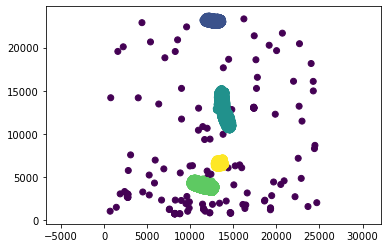

In [6]:
# Here I visualise the clustering and you can see the background is separated from the sample cells
plt.scatter(df.x,df.y, c=df.cell_cluster)
plt.axis('equal')

In [7]:
# Background with label -1 is removed
df=df[(df['cell_cluster'] != -1)]
df.shape

(9600, 8)

(9697.021768434177, 15189.800979542924, 2156.023565440289, 24663.605765707805)

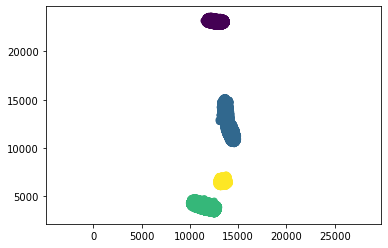

In [8]:
# Localisations from the cell without the background is visualised
plt.scatter(df.x,df.y, c=df.cell_cluster)
plt.axis('equal')

(array([   0.,    0.,    0.,    0.,   26.,   68.,  122.,  208.,  458.,
         474.,  612.,  829.,  726.,  663.,  856.,  813.,  801., 1040.,
        1018.,  646.,  218.,   22.,    0.]),
 array([-600, -550, -500, -450, -400, -350, -300, -250, -200, -150, -100,
         -50,    0,   50,  100,  150,  200,  250,  300,  350,  400,  450,
         500,  550]),
 <BarContainer object of 23 artists>)

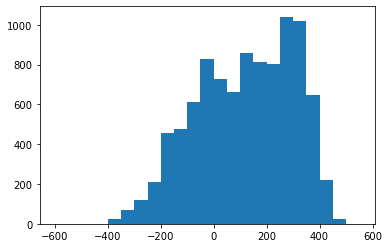

In [9]:
# In 3D-STORM microscopy the data in all z may not be reliable and you want to choose/filter certain z region
# Here I plot z histogram to select good region/range for z filter
bin_edges = np.arange(-600, 600, 50)
plt.hist(df.z, bins = bin_edges)

In [10]:
# Here I apply the filter with z range
# specific to each file
df=df[(df['z'] >= -200) & (df['z'] <= 400)]

In [11]:
df.shape

(8936, 8)

(9697.021768434177, 15189.800979542924, 2156.023565440289, 24663.605765707805)

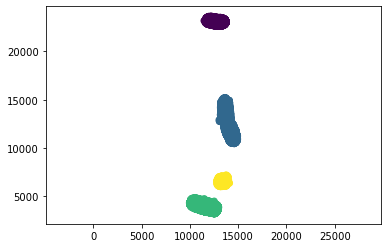

In [12]:
# Here, I plot the final clean data without the background and after z filter
plt.scatter(df.x,df.y, c=df.cell_cluster)
plt.axis('equal')

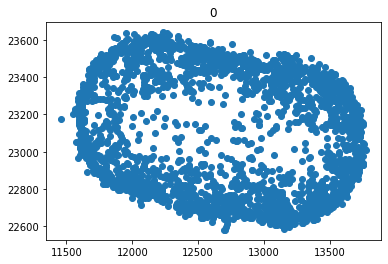

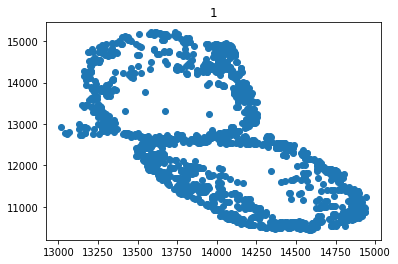

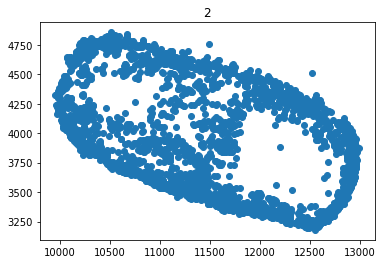

In [13]:
# Here I visualise each of the cells separately
for cell_number in range(max(df.cell_cluster)):
    x=df.x[df.cell_cluster==cell_number]
    y=df.y[df.cell_cluster==cell_number]
    plt.scatter(x,y)
    plt.title(cell_number)
    plt.show()

In [14]:
# The clean data is saved as a csv file
df.to_csv('df_vutara_drift_corrected_filtered_cam1_2_localisations_cells.csv', index=False)